<a href="https://colab.research.google.com/github/JonasRiber/Dl_project_HAM10000/blob/main/ham_1000_CVS_under_over_augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


data = pd.read_csv("/content/drive/My Drive/archive/hmnist_28_28_RGB.csv")
data.head()
meta_df = pd.read_csv("/content/drive/My Drive/archive/HAM10000_metadata.csv")
meta_df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
## chaking the shape of our data

print(meta_df.shape)
print(data.shape)



(10015, 7)
(10015, 2353)


In [ ]:
### cheking the distrobution of the data in each class
yData = data['label']
XData = data.drop(columns = ['label'])
# EDA
distribution = meta_df['dx'].value_counts()
distribution
# classes = {4: ('nv', ' Nevus'),
#            6: ('mel', 'Melanoma'),
#            2 :('bkl', 'Seborrheic Keratosis'),
#            1:('bcc' , ' Basal Cell Carcinoma '),
#            5: ('vasc', 'Vascular Lesion'),
#            0: ('akiec', 'Actinic Keratosis'),
#            3: ('df', 'Dermatofibroma')}

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


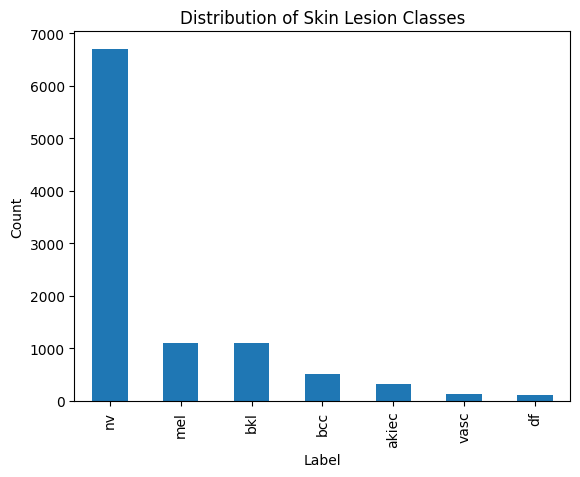

In [ ]:
# Create the histogram
distribution.plot(kind='bar')  # Use kind='bar' for a histogram
plt.title('Distribution of Skin Lesion Classes')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Undersample

In [ ]:

from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# 1. Initialize RandomUnderSampler
sampler = RandomUnderSampler()

# 2. Perform Undersampling
XData, yData = sampler.fit_resample(XData, yData)

# 3. Reshape and Normalize
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255.0

XData.shape, yData.shape


((805, 28, 28, 3), (805,))

### create the train and validation set

In [ ]:

# Creating the train and validation set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape



((644, 28, 28, 3), (161, 28, 28, 3))

### Bilding CNN
1) imports funtions from keras

2) input shape: input_shape = (28, 28, 3) defines the shape of the input data. This indicates that the model will receive images that are 28 pixels in height and 28 pixels in width with 3 color channels (RGB)

3) Number of Classes: num_classes = 7

In [ ]:


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, ZeroPadding2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

input_shape = (28, 28, 3)
num_classes = 7



### resnet 50

In [ ]:
### resize
Xtrain_resized = tf.image.resize(Xtrain, (32, 32))
Xtest_resized = tf.image.resize(Xtest, (32, 32))

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

Resnet = Model(inputs=base_model.input, outputs=predictions)

Resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
history = Resnet.fit(Xtrain_resized, Ytrain,
                           validation_data=(Xtest_resized, Ytest),
                           epochs=10)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2326 - loss: 2.7264 - val_accuracy: 0.1801 - val_loss: 229.5009
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - accuracy: 0.4385 - loss: 2.0356 - val_accuracy: 0.1677 - val_loss: 420.8204
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3753 - loss: 1.9036 - val_accuracy: 0.1801 - val_loss: 264.5099
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4386 - loss: 1.7013 - val_accuracy: 0.1801 - val_loss: 63.6354
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5129 - loss: 1.4610 - val_accuracy: 0.1677 - val_loss: 51.5568
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4856 - loss: 1.4361 - val_accuracy: 0.1801 - val_loss: 252.9004
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5746 - loss: 1.3193 - val_accuracy: 0.0932 - val_loss: 2.7487
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6298 - loss: 1.1288 - val_accuracy: 

#### Table loss and accuracy

In [ ]:
from tabulate import tabulate

loss_resnet, accuracy_resnet = Resnet.evaluate(Xtest_resized, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_resnet * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_resnet)]]

print(tabulate(table, tablefmt="grid"))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1066 - loss: 6.7630 
+---------------+--------+
| Test Accuracy | 9.32%  |
+---------------+--------+
| Test Loss     | 6.8312 |
+---------------+--------+


#### Confusion matrix

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 552ms/step

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        27
           2       0.00      0.00      0.00        24
           3       0.09      1.00      0.17        15
           4       0.00      0.00      0.00        29
           5       0.00      0.00      0.00        27
           6       0.00      0.00      0.00        17

    accuracy                           0.09       161
   macro avg       0.01      0.14      0.02       161
weighted avg       0.01      0.09      0.02       161



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


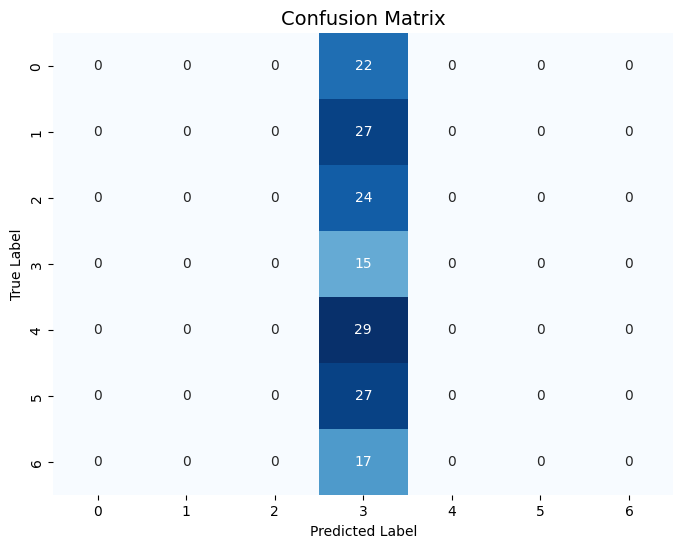

In [ ]:


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Ypred_resnet50 = Resnet.predict(Xtest_resized)
Ypred_resnet50 = Ypred_resnet50.argmax(axis=1)



print("\n\033[1mClassification Report\033[0m")
print(classification_report(Ytest, Ypred_resnet50))


conf_matrix = confusion_matrix(Ytest, Ypred_resnet50)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#### Training and Validation Accuracy


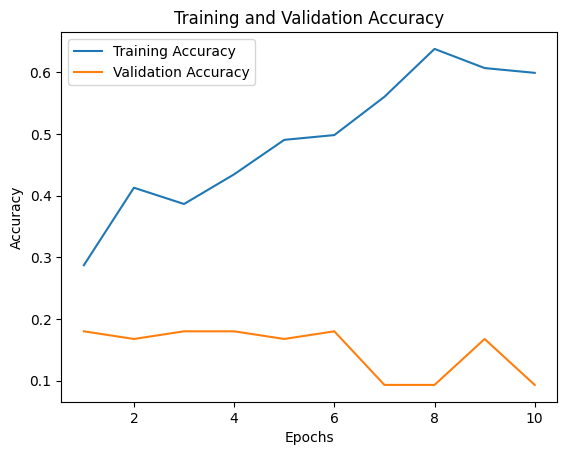

In [ ]:


import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



#### Traning and Validaation loss

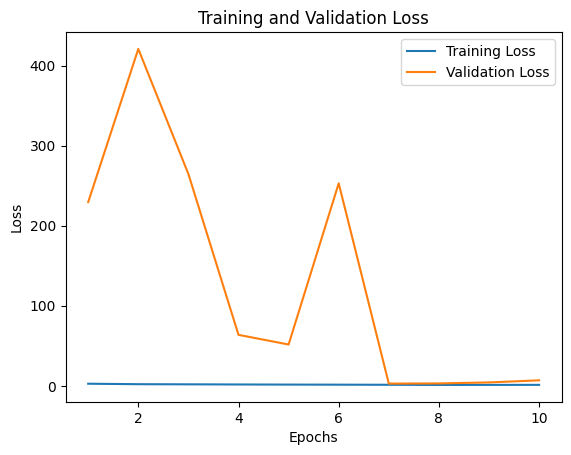

In [ ]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Oversampling


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


data = pd.read_csv("/content/drive/My Drive/archive/hmnist_28_28_RGB.csv")
data.head()
meta_df = pd.read_csv("/content/drive/My Drive/archive/HAM10000_metadata.csv")
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
## chaking the shape of our data

print(meta_df.shape)
print(data.shape)

(10015, 7)
(10015, 2353)


In [ ]:
### cheking the distrobution of the data in each class
yData = data['label']
XData = data.drop(columns = ['label'])
# EDA
distribution = meta_df['dx'].value_counts()
distribution

,count
dx,
nv,6705
mel,1113
bkl,1099
bcc,514
akiec,327
vasc,142
df,115


In [ ]:
# Fixing Data Imbalance
from imblearn.over_sampling import RandomOverSampler #
# 1. Initialize RandomOverSampler
sampler = RandomOverSampler()
# 2. Perform Oversampling
XData,yData  = sampler.fit_resample(XData,yData)
XData.shape, yData.shape
# 3. Reshape and Normalize
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape

(46935, 28, 28, 3)

In [ ]:
# Creating the train and validation set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape

((37548, 28, 28, 3), (9387, 28, 28, 3))

In [ ]:
import tensorflow as tf
### resize
Xtrain_resized = tf.image.resize(Xtrain, (32, 32))
Xtest_resized = tf.image.resize(Xtest, (32, 32))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, ZeroPadding2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

input_shape = (28, 28, 3)
num_classes = 7

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

Resnet = Model(inputs=base_model.input, outputs=predictions)

Resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
history_over = Resnet.fit(Xtrain_resized, Ytrain,
                           validation_data=(Xtest_resized, Ytest),
                           epochs=10)

Epoch 1/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 125s 57ms/step - accuracy: 0.5522 - loss: 1.3424 - val_accuracy: 0.6187 - val_loss: 1.1681
Epoch 2/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 87s 32ms/step - accuracy: 0.7579 - loss: 0.6699 - val_accuracy: 0.7438 - val_loss: 0.7340
Epoch 3/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8178 - loss: 0.5046 - val_accuracy: 0.6666 - val_loss: 1.1173
Epoch 4/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.8353 - loss: 0.4709 - val_accuracy: 0.7640 - val_loss: 0.6801
Epoch 5/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.8046 - loss: 0.5323 - val_accuracy: 0.8821 - val_loss: 0.3215
Epoch 6/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.8287 - loss: 0.5028 - val_accuracy: 0.8267 - val_loss: 0.4791
Epoch 7/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.9117 - loss: 0.2626 - val_accuracy: 0.8996 - val_loss: 0.2778
Epoch 8/10
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - accuracy: 0.9315 

#### Table loss and accuracy


In [ ]:
from tabulate import tabulate

loss_resnet, accuracy_resnet = Resnet.evaluate(Xtest_resized, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_resnet * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_resnet)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9164 - loss: 0.2500
+---------------+--------+
| Test Accuracy | 91.52% |
+---------------+--------+
| Test Loss     | 0.2553 |
+---------------+--------+


#### Confusion matrix

294/294 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1310
           1       0.99      0.91      0.95      1353
           2       0.88      0.89      0.89      1363
           3       0.98      1.00      0.99      1380
           4       0.83      0.77      0.80      1382
           5       0.99      0.99      0.99      1308
           6       0.78      0.93      0.85      1291

    accuracy                           0.92      9387
   macro avg       0.92      0.92      0.92      9387
weighted avg       0.92      0.92      0.92      9387



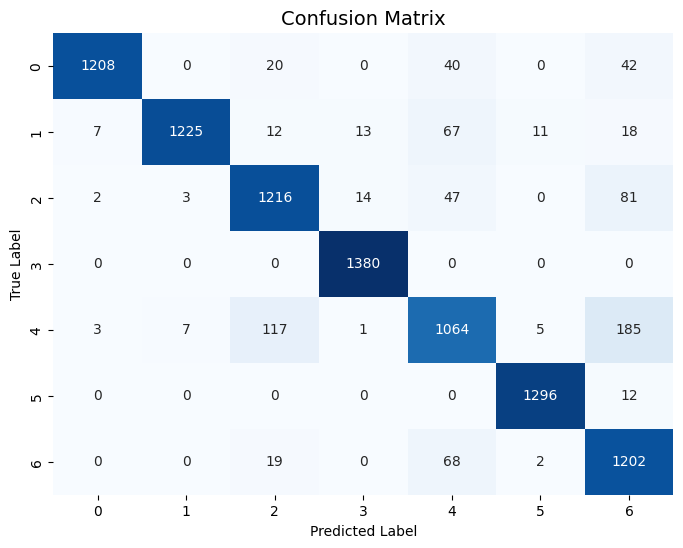

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Ypred_resnet50 = Resnet.predict(Xtest_resized)
Ypred_resnet50 = Ypred_resnet50.argmax(axis=1)



print("\n\033[1mClassification Report\033[0m")
print(classification_report(Ytest, Ypred_resnet50))


conf_matrix = confusion_matrix(Ytest, Ypred_resnet50)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Training and validation accuracy

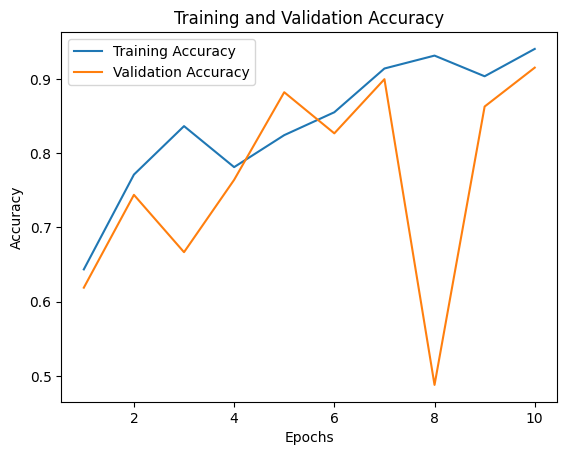

In [ ]:
import matplotlib.pyplot as plt

train_acc = history_over.history['accuracy']
val_acc = history_over.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Training and Validation Loss

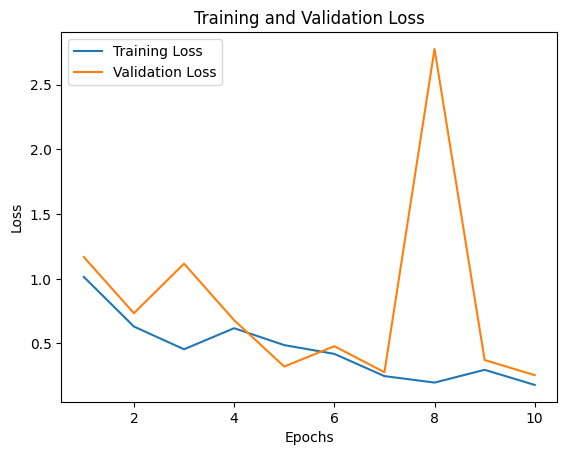

In [ ]:
import matplotlib.pyplot as plt

train_loss = history_over.history['loss']
val_loss = history_over.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Data augmentation

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


data = pd.read_csv("/content/drive/My Drive/archive/hmnist_28_28_RGB.csv")
data.head()
meta_df = pd.read_csv("/content/drive/My Drive/archive/HAM10000_metadata.csv")
meta_df.head()

## chaking the shape of our data

print(meta_df.shape)
print(data.shape)

### cheking the distrobution of the data in each class
yData = data['label']
XData = data.drop(columns = ['label'])
# EDA
distribution = meta_df['dx'].value_counts()
distribution

# Fixing Data Imbalance
from imblearn.over_sampling import RandomOverSampler #
# 1. Initialize RandomOverSampler
sampler = RandomOverSampler()
# 2. Perform Oversampling
XData,yData  = sampler.fit_resample(XData,yData)
XData.shape, yData.shape
# 3. Reshape and Normalize
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape

# Creating the train and validation set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape

import tensorflow as tf
### resize
Xtrain_resized = tf.image.resize(Xtrain, (32, 32))
Xtest_resized = tf.image.resize(Xtest, (32, 32))

(10015, 7)
(10015, 2353)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,       # Randomly rotate images in the range 0-20 degrees
    width_shift_range=0.2,   # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,         # Shearing transformations
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill missing pixels after transformations
)

# Apply data augmentation to the training data only
train_datagen = datagen.flow(Xtrain_resized, Ytrain, batch_size=32)

# Validation data should not be augmented
test_datagen = ImageDataGenerator()
test_datagen_flow = test_datagen.flow(Xtest_resized, Ytest, batch_size=32)

# Model creation (from your code)
input_shape = (32, 32, 3)
num_classes = 7

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
Resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
Resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])





In [ ]:
# Train the model with augmented data
history_over_augment = Resnet.fit(train_datagen, validation_data=test_datagen_flow, epochs=20)

Epoch 1/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 50s 43ms/step - accuracy: 0.6834 - loss: 0.8408 - val_accuracy: 0.5198 - val_loss: 1.4514
Epoch 2/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.6338 - loss: 0.9800 - val_accuracy: 0.6594 - val_loss: 0.8983
Epoch 3/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 78s 40ms/step - accuracy: 0.6792 - loss: 0.8424 - val_accuracy: 0.6264 - val_loss: 0.9774
Epoch 4/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 51s 43ms/step - accuracy: 0.6834 - loss: 0.8399 - val_accuracy: 0.5590 - val_loss: 1.2155
Epoch 5/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.6902 - loss: 0.8204 - val_accuracy: 0.5933 - val_loss: 1.0697
Epoch 6/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.6564 - loss: 0.9228 - val_accuracy: 0.6153 - val_loss: 1.2988
Epoch 7/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 48s 41ms/step - accuracy: 0.7126 - loss: 0.7829 - val_accuracy: 0.6188 - val_loss: 1.0338
Epoch 8/20
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.7104 -

#### Confusion matrix

294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.83      0.77      1325
           1       0.80      0.73      0.77      1347
           2       0.58      0.66      0.62      1361
           3       0.91      0.98      0.94      1365
           4       0.80      0.64      0.71      1324
           5       0.98      0.91      0.95      1328
           6       0.65      0.65      0.65      1337

    accuracy                           0.77      9387
   macro avg       0.78      0.77      0.77      9387
weighted avg       0.78      0.77      0.77      9387



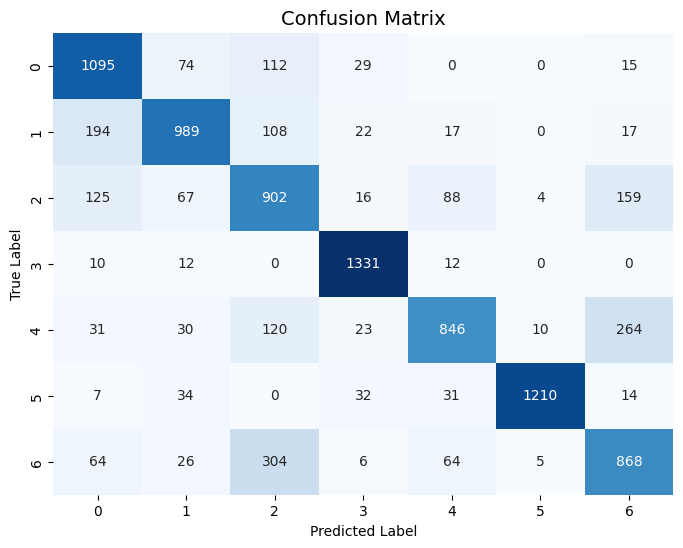

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Ypred_resnet50_augment = Resnet.predict(Xtest_resized)
Ypred_resnet50_augment = Ypred_resnet50_augment.argmax(axis=1)



print("\n\033[1mClassification Report\033[0m")
print(classification_report(Ytest, Ypred_resnet50_augment))


conf_matrix = confusion_matrix(Ytest, Ypred_resnet50_augment)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix", fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Training and validation accuracy

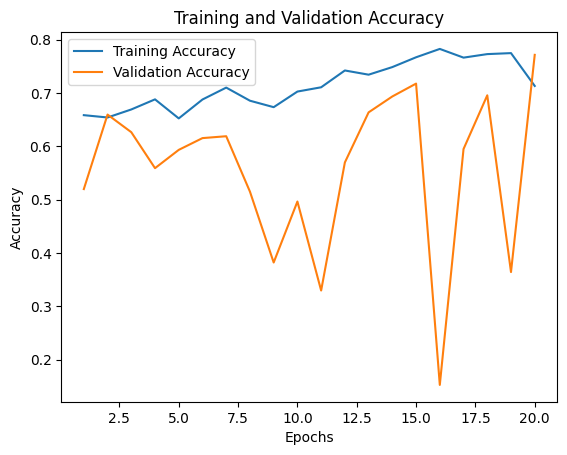

In [ ]:
import matplotlib.pyplot as plt

train_acc = history_over_augment.history['accuracy']
val_acc = history_over_augment.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Training and Validation Loss

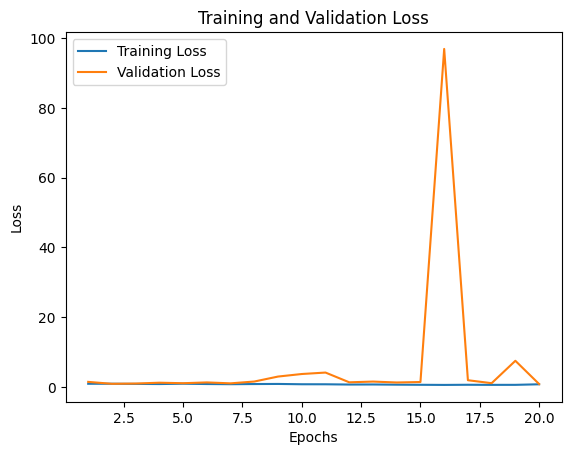

In [ ]:
import matplotlib.pyplot as plt

train_loss = history_over_augment.history['loss']
val_loss = history_over_augment.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Prediction

294/294 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


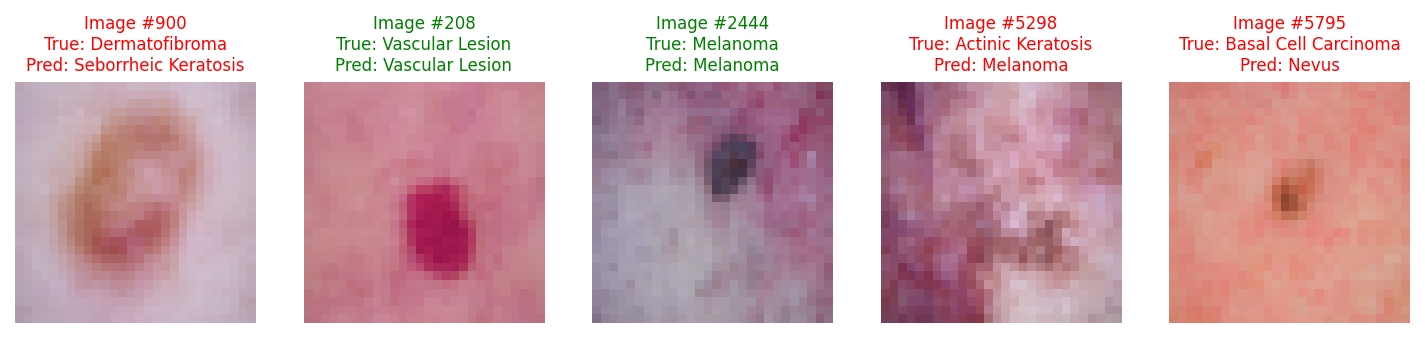

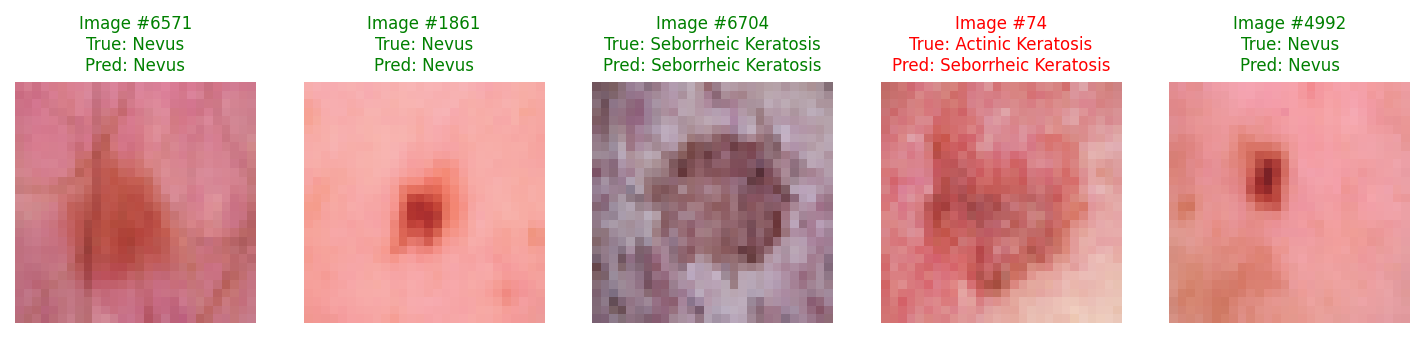

In [ ]:
Ytest = np.array(Ytest)
import numpy as np
import matplotlib.pyplot as plt
classes = {
    4: ('Nevus'),
    6: ('Melanoma'),
    2: ('Seborrheic Keratosis'),
    1: ('Basal Cell Carcinoma'),
    5: ('Vascular Lesion'),
    0: ('Actinic Keratosis'),
    3: ('Dermatofibroma')
}

test_pred = Resnet.predict(Xtest)

test_pred = np.argmax(test_pred, axis=1)

def random_test_sample_with_prediction(SEED):
    num_samples = len(Xtest)
    idxs = np.random.default_rng(seed=SEED).permutation(num_samples)[:5]


    fig, axs = plt.subplots(1, 5, figsize=(12, 12), dpi=150)

    for i, idx in enumerate(idxs):

        img = Xtest[idx]
        true_label = Ytest[idx]
        pred_label = test_pred[idx]

        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')

        title_color = 'green' if true_label == pred_label else 'red'
        axs[i].set_title(f"Image #{idx}\nTrue: {classes[true_label]}\nPred: {classes[pred_label]}",
                         fontsize=8, color=title_color)

random_test_sample_with_prediction(SEED=42)
random_test_sample_with_prediction(SEED=120)